In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# The purpuse

If I can see that the evoluton of the pandemic is in line with well-known models of pandemia it makes me calmer because I can understand the underlying processes better. 

My purpuse was to follow the latest figures and see whether the pandemia turns to better or worse than we expected a few days earlier.

# The setup

The purpose is to fit a *logistic*, an *exponential* and a *Generalized Richards Model (GRM)* to the daily number of registered Hungarian Covid-19 cases.

These functions have the following forms:

Logistic $$f_{logit}(x) = \frac{a}{1 + b * e^{-c * x}} + d$$

Exponential $$f_{exp}(x) = z * e^{v * x} + w$$

where $x$ is the number of days since he first registered patient, $a, b, c, z, v$ are parameters to estimate, $d$ and $w$ are initial number of patients. Given the number of cases was initially zero $d=w=0$.

Generalized Richards Model (GRM) $$\frac{dC(t)}{dt} = r*C^p(t)*\left(1-\left(\frac{C(t)}{K} \right)^\alpha\right)$$

which described the number of new cases $C(t)$ at $t$. $C(0)$ is the number of initial cases, while we will estimate $r, p, K$ and \$alpha$.  

Logistic

In [2]:
def f_logit(x, a, b, c):
    return a / (1. + b * np.exp(-c * x))

Exponential

In [3]:
def f_exp(x, z, v):
    return z * np.exp(v * x)

Richards' Model (RM)

In [4]:
def f_RM(x, K, Q, r, nu):
    return K / ((1. + Q * np.exp(-r * x))**(1/nu))

In [5]:
f_RM(100000, 100, 10000, 0.4, 0.5)

100.0

Generalized Richards Model (GRM)

For more details see Ke Wu et al. 
https://arxiv.org/ftp/arxiv/papers/2003/2003.05681.pdf

In [6]:
#The dynamics
def velocity_GRM(Ct, K, r, p, alpha):
    return r*(Ct**p)*(1-(Ct/K)**alpha)

def f_GRM(x, C0, K, r, p, alpha):
    output = []
    for xi in x:
        evolution = [C0]
        for n in range(0,xi):
            if n>0:
                evolution.append(velocity_GRM(np.cumsum(evolution)[n-1], K, r, p, alpha))
                #print(np.cumsum(evolution)[n-1])
        output.append(sum(evolution))
    return output

In [7]:
f_GRM([10000], 2, 100, 0.25, 1, 1)

[99.99999999999999]

# Data

Because I did not find official sources I scraped the Hunarian wikipedia page:
https://hu.wikipedia.org/wiki/2020-as_COVID-19_koronav%C3%ADrus-j%C3%A1rv%C3%A1ny_Magyarorsz%C3%A1gon

In [419]:
import requests
import lxml.html as lh

url='https://hu.wikipedia.org/wiki/2020-as_COVID-19_koronav%C3%ADrus-j%C3%A1rv%C3%A1ny_Magyarorsz%C3%A1gon'

#Create a handle, page, to handle the contents of the website
page = requests.get(url)

#Store the contents of the website under doc
doc = lh.fromstring(page.content)

#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')

Sanity check

In [420]:
#For sanity check see the length of the first 12 rows
[len(T) for T in tr_elements[:12]]

[2, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]

Processing the header

In [421]:
#At the time of the implementation the first 3 rows contain a disclaimer
table_starts_at = 1

#Create empty list
col=[]
i=0

#For each row, store each first element (header) and an empty list
for t in tr_elements[table_starts_at]:
    i+=1
    name=t.text_content()
    col.append((name,[]))

Processing the body

In [422]:
#Since out first row is the header, data is stored on the second row onwards
for j in range(table_starts_at+1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 9, the //tr data is not from our table 
    if len(T)!=9:
        print('Length of row {} is different from 9 cells'.format(j-table_starts_at))
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content() 
        #Check if row is empty
        if i>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1

Length of row 54 is different from 9 cells


Sanity check

In [423]:
#Check the length of each column
[len(C) for (title,C) in col]

[53, 53, 53, 53, 53, 53, 53, 53, 53]

Dataframe

In [424]:
col

[('Dátum[84]\n',
  ['2020‑03‑04',
   '2020-03-05',
   '2020-03-06',
   '2020-03-07',
   '2020-03-08',
   '2020-03-09',
   '2020-03-10',
   '2020-03-11',
   '2020-03-12',
   '2020-03-13',
   '2020-03-14',
   '2020-03-15',
   '2020-03-16',
   '2020-03-17',
   '2020-03-18',
   '2020-03-19',
   '2020-03-20',
   '2020-03-21',
   '2020-03-22',
   '2020-03-23',
   '2020-03-24',
   '2020-03-25',
   '2020-03-26',
   '2020-03-27',
   '2020-03-28',
   '2020-03-29',
   '2020-03-30',
   '2020-03-31',
   '2020-04-01',
   '2020-04-02',
   '2020-04-03',
   '2020-04-04',
   '2020-04-05',
   '2020-04-06',
   '2020-04-07',
   '2020-04-08',
   '2020-04-09',
   '2020-04-10',
   '2020-04-11',
   '2020-04-12',
   '2020-04-13',
   '2020-04-14',
   '2020-04-15',
   '2020-04-16',
   '2020-04-17',
   '2020-04-18',
   '2020-04-19',
   '2020-04-20',
   '2020-04-21',
   '2020-04-22',
   '2020-04-23',
   '2020-04-24',
   '2020-04-25']),
 ('Aktív fertőzött\n',
  [2,
   4,
   4,
   5,
   7,
   9,
   12,
   13,
   15,


In [425]:
Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)

# English header
df.columns = ['Date', 'Sick','Died','Recovered','Total','Delta Sick','Delta Died','Delta Recovered','New Patient']


#It might look insane but the two '-'-s are different and caused a lot of troubles when converting to datetime
df['Date'] = pd.to_datetime(df['Date'].str.replace('‑','-'))
print(ord(u"‑"))
print(ord(u"-"))

# Store the number of days since onset
df.reset_index(inplace=True)
df.set_index('Date',inplace=True)

df.rename(columns={ df.columns[0]: "Day" }, inplace = True)

8209
45


Let's see the data

(array([18325, 18353, 18377], dtype=int64),
 <a list of 3 Text xticklabel objects>)

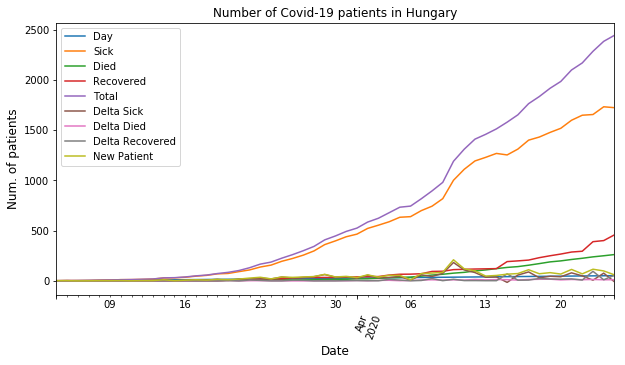

In [426]:
df.plot(figsize=(10,5))
plt.xlabel('Date')
plt.ylabel('Num. of patients')
plt.title('Number of Covid-19 patients in Hungary')
degrees = 70
plt.xticks(rotation=degrees)

Import number of test from Excel sheet

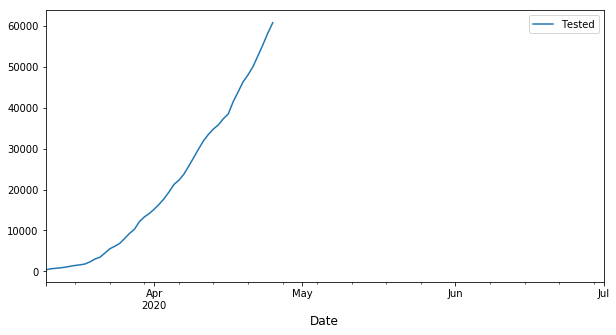

In [427]:
tested = pd.read_excel (r'korona.xlsx',skiprows=3, usecols=[0,10])
tested.columns = ['Date', 'Tested']
tested.set_index('Date',inplace=True)

tested.plot(figsize=(10,5))

Join the two DataFrames

In [428]:
df = pd.merge(df, tested, left_index=True,  right_index=True, how='left')

# Curve fitting

Exponential

In [429]:
parameters_exp, pcov_exp  = opt.curve_fit(f_exp, df['Day'].to_numpy()+1, df['Total'].to_numpy(),bounds=([0,0.05], [10e10,0.9]))
perr_exp = np.sqrt(np.diag(pcov_exp))

extrapol_horizon = 3
long_extrapol_horizon = 14

fitting_horizon = np.array(range(1,np.max(df['Day'].to_numpy()+2)+extrapol_horizon))
long_fitting_horizon = np.array(range(1,np.max(df['Day'].to_numpy()+2)+long_extrapol_horizon))

y_fit_exp = f_exp(fitting_horizon, *parameters_exp)
long_y_fit_exp = f_exp(long_fitting_horizon, *parameters_exp)

#Fit a version on older data to see the changes of predictions
parameters_exp_old, pcov_exp_old  = opt.curve_fit(f_exp, df['Day'].to_numpy()[:-5]+1, df['Total'].to_numpy()[:-5],bounds=([0,0.05], [10e10,0.9]))
long_y_fit_exp_old = f_exp(long_fitting_horizon, *parameters_exp_old)

#Dates
times = pd.date_range('2020-03-04', periods=len(df['Day'])+extrapol_horizon, freq='D')
long_times = pd.date_range('2020-03-04', periods=len(df['Day'])+long_extrapol_horizon, freq='D')

In [430]:
parameters_exp

array([7.77394404e+01, 6.72677196e-02])

In [431]:
parameters_exp_old

array([52.96242368,  0.07791479])

Confidece intervals

In [432]:
# prepare confidence level curves
nstd = 1. # to draw 1-sigma intervals
parameters_exp_up = parameters_exp + nstd * perr_exp
parameters_exp_dw = parameters_exp - nstd * perr_exp

fit_up = f_exp(fitting_horizon, *parameters_exp_up)
fit_dw = f_exp(fitting_horizon, *parameters_exp_dw)

In [433]:
parameters_exp_dw

array([6.91820814e+01, 6.49090188e-02])

In [434]:
parameters_exp

array([7.77394404e+01, 6.72677196e-02])

Logistic

In [435]:
#parameters_logit = np.array([1200,1000,0.26])
# a is the final epidemic size
# b is related to C0, doesn't affect the later evlution of the process 
# c is the growth rate at the early stage

parameters_logit, pcov_logit  = opt.curve_fit(f_logit, df['Day'].to_numpy()+1, df['Total'].to_numpy(),bounds=([100,100,0.2], [10e6,10e6,0.3]))
perr_logit = np.sqrt(np.diag(pcov_logit))

y_fit_logit = f_logit(fitting_horizon, *parameters_logit)
long_y_fit_logit = f_logit(long_fitting_horizon, *parameters_logit)

#Fit a version on older data to see the changes of predictions
parameters_logit_old, pcov_logit_old  = opt.curve_fit(f_logit, df['Day'].to_numpy()[:-5]+1, df['Total'].to_numpy()[:-5])
long_y_fit_logit_old = f_logit(long_fitting_horizon, *parameters_logit_old)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [437]:
parameters_logit

array([2.28871607e+03, 1.76605080e+03, 2.00000000e-01])

In [438]:
parameters_logit_old

array([2.64461788e+03, 2.22407653e+02, 1.35448992e-01])

In [439]:
np.diag(pcov_logit)

array([5.46119521e+03, 6.98155766e+05, 2.06066155e-04])

Richards' Model (RM) - This is practically identical to the Logistic Model

In [440]:
#f_RM(x, K, Q, r, nu)
parameters_RM, pcov_RM  = opt.curve_fit(f_RM, df['Day'].to_numpy()+1, df['Total'].to_numpy(),bounds=([100,100,0.2,0.5], [10e6,10e6,0.3,0.99]))
#perr_RM = np.sqrt(np.diag(pcov_RM))

In [441]:
parameters_RM

array([2.28615690e+03, 1.73398259e+03, 2.00000000e-01, 9.90000000e-01])

Generalized Richards Model (GRM)

Parameters guesses are based on Ke Wu et al. 
https://arxiv.org/ftp/arxiv/papers/2003/2003.05681.pdf

In [442]:
# C0 is the number of initial cases
# K is the final epidemic size
# r is the growth rate at the early stage
# p is a parameter that allows the model to capture different growth profiles (e.g. sub-exp, exponential)
# alpha measures the deviation from the symmetric s-shaped dynamics of the simple logistic curve

C0 = df['Total'].to_numpy()[0]
K = 1200 #Hopefully lower than the original Chinese (excl. Hubei) sample K~13.000 in Ke Wu et al.

r_empiricial = (np.log(df['Total'].to_numpy()[18])-np.log(df['Total'].to_numpy()[0]))/18
print(r_empiricial)
r = 0.23 #4.87 in Ke Wu et al. 

p = 1 #0.63 in Ke Wu et al., p=1 logistic case 
alpha = 1 #1.42 in Ke Wu et al., alpha=1 logistic case  

parameters_GRM = (C0,K,r,p,alpha)
parameters_GRM, pcov_GRM  = opt.curve_fit(f_GRM, df['Day'].to_numpy()+1, df['Total'].to_numpy(),p0=parameters_GRM,bounds=([1.99,100,0.2,0.5,0.5], [2,10e6,5,1,5]))

y_fit_GRM = f_GRM(fitting_horizon, *parameters_GRM)
long_y_fit_GRM = f_GRM(long_fitting_horizon, *parameters_GRM)

0.23233611903562254


In [443]:
parameters_GRM

array([1.99000000e+00, 3.53437074e+03, 5.27891333e-01, 7.65900173e-01,
       1.16250573e+00])

In [444]:
r_empiricial

0.23233611903562254

# Plots

Generate ldate labels

In [445]:
observed_dates = times[:len(df['Total'])].strftime("%m/%d")
all_dates = times.strftime("%m/%d")
long_all_dates = long_times.strftime("%m/%d")

Plotting

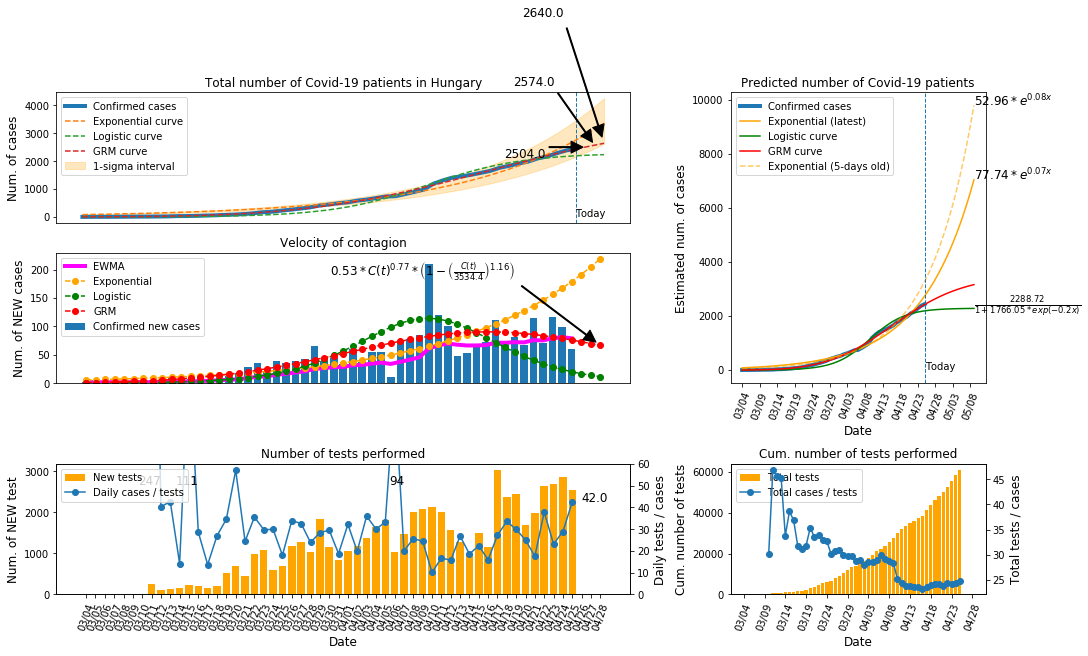

In [446]:
degrees = 70

fig = plt.figure(figsize=(15, 9),constrained_layout=True)
gs = fig.add_gridspec(3, 9)

ax1= fig.add_subplot(gs[:2, 5:9])
ax1.plot(observed_dates,df['Total'],linewidth=4,label='Confirmed cases')
ax1.plot(long_all_dates,long_y_fit_exp,color='orange',label='Exponential (latest)')
ax1.plot(long_all_dates,long_y_fit_logit,color='green',label='Logistic curve')
ax1.plot(long_all_dates,long_y_fit_GRM,color='red',label='GRM curve')

ax1.plot(long_all_dates,long_y_fit_exp_old,'--',color='orange',label='Exponential (5-days old)',alpha=0.6)
#ax1.plot(long_all_dates,long_y_fit_logit_old,'--',color='green',label='Logistic (5-days old)',alpha=0.6)

ax1.set_xticks(ax1.get_xticks()[::5])
ax1.set_xticklabels(long_all_dates[::5],rotation=degrees)
ax1.set(xlabel='Date')

ax1.legend(loc='best')

ax1.axvline(long_all_dates[-long_extrapol_horizon-1],linestyle='dashed',linewidth=1,label='Today')
ax1.annotate('Today',xy=(long_all_dates[-long_extrapol_horizon-1],5))
ax1.set(ylabel='Estimated num. of cases')
ax1.set(title='Predicted number of Covid-19 patients')


ax1.annotate('${}*e^{{ {}x}}$'.format(round(parameters_exp[0],2),round(parameters_exp[1],2)),xy=(long_all_dates[-1:],long_y_fit_exp[-1:]),fontsize=12)
ax1.annotate('${}*e^{{ {}x}}$'.format(round(parameters_exp_old[0],2),round(parameters_exp_old[1],2)),xy=(long_all_dates[-1:],long_y_fit_exp_old[-1:]),fontsize=12)
ax1.annotate('$\\frac{{ {} }}{{ 1+{}*exp(-{}x) }}$'.format(round(parameters_logit[0],2),round(parameters_logit[1],2),round(parameters_logit[2],2)),xy=(long_all_dates[-1:],long_y_fit_logit[-1:]),fontsize=12)


#ax1.set_yscale('log')


#--------------------

ax2 = fig.add_subplot(gs[0, 0:5])
ax2.plot(observed_dates,df['Total'],linewidth=4,label='Confirmed cases')
ax2.get_xaxis().set_ticks([])

ax2.set(ylabel='Num. of cases')
ax2.set(title='Total number of Covid-19 patients in Hungary')


ax2.plot(all_dates,y_fit_exp,'--',label='Exponential curve')
ax2.plot(all_dates,y_fit_logit,'--',label='Logistic curve')
ax2.plot(all_dates,y_fit_GRM,'--',label='GRM curve')

for i,j in zip(all_dates[-extrapol_horizon:],y_fit_GRM[-extrapol_horizon:]):
    ax2.annotate(str(round(j)),xy=(i,j),fontsize=12,
                 horizontalalignment='right',
                 verticalalignment='top',
                 xytext=(-40, j-y_fit_GRM[-extrapol_horizon]), 
                 textcoords='offset points',
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1),)
              

ax2.fill_between(all_dates, fit_up, fit_dw, alpha=.25, label='1-sigma interval',color='orange')
#ax2.set_yscale('log')
ax2.legend(loc='best')

ax2.axvline(all_dates[-extrapol_horizon-1],linestyle='dashed',linewidth=1,label='Today')
ax2.annotate('Today',xy=(all_dates[-extrapol_horizon-1],5))

#ax2.annotate('${}*exp({}*x)$'.format(round(parameters_exp[0],2),round(parameters_exp[1],2)),xy=(all_dates[-4],fit_dw[-4]))

#--------------------

ax3 = fig.add_subplot(gs[1, 0:5])
ax3.bar(all_dates,np.concatenate((df['Total'].diff(), np.full(len(all_dates)-len(observed_dates), 0)), axis=0),label='Confirmed new cases')
ax3.plot(all_dates,np.concatenate((df['Total'].diff().ewm(halflife=7,adjust=False).mean(), np.full(len(all_dates)-len(observed_dates), np.nan)), axis=0),color='magenta',linewidth=4,label='EWMA')
ax3.plot(all_dates,np.concatenate(([np.nan],np.diff(y_fit_exp))),'--',color='orange',marker='o',label='Exponential')
ax3.plot(all_dates,np.concatenate(([np.nan],np.diff(y_fit_logit))),'g--',marker='o',label='Logistic')
ax3.plot(all_dates,np.concatenate(([np.nan],np.diff(y_fit_GRM))),'r--',marker='o',label='GRM')
ax3.get_xaxis().set_ticks([])

ax3.annotate('${}*C(t)^{{ {} }}*\\left(1-\\left( \\frac{{C(t)}} {{ {} }} \\right)^{{ {} }} \\right)$'.format(round(parameters_GRM[2],2),round(parameters_GRM[3],2),round(parameters_GRM[1],1),round(parameters_GRM[4],2)),
            xy=(all_dates[-1:],np.diff(y_fit_GRM)[-1:]),
            fontsize=12,
            xytext=(0.8, 0.95), 
            textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05, width=1),
            horizontalalignment='right', verticalalignment='top')

ax3.set(ylabel='Num. of NEW cases')
ax3.set(title='Velocity of contagion')
ax3.set_xticklabels(all_dates,rotation=degrees)

ax3.legend(loc='upper left')

#--------------------

ax4 = fig.add_subplot(gs[2, 0:5])
ax4.bar(all_dates,np.nan_to_num(np.concatenate((df['Tested'].diff(), np.full(len(all_dates)-len(observed_dates), 0)))),color='orange',label='New tests')
ax5 = ax4.twinx()
ax5.plot(all_dates,np.concatenate(((df['Tested'].diff()/df['Total'].diff()), np.full(len(all_dates)-len(observed_dates), np.nan)), axis=0),marker='o',label='Daily cases / tests')

y_max = 60
ax5.set_ylim(0,60)

ax5.annotate(str(round((df['Tested'].diff()/df['Total'].diff())[-1])),
            xy=(all_dates[-3],(df['Tested'].diff()/df['Total'].diff())[-1]),
            fontsize=12,)

for i,j in zip(all_dates[1:-extrapol_horizon],(df['Tested'].diff()/df['Total'].diff())[:-extrapol_horizon]):
    if j>y_max:
        ax5.annotate(str(round(j)),xy=(i,y_max-5),fontsize=12,
                     horizontalalignment='right',
                     verticalalignment='top',)


lines_1, labels_1 = ax4.get_legend_handles_labels()
lines_2, labels_2 = ax5.get_legend_handles_labels()

lines = lines_1 + lines_2
labels = labels_1 + labels_2

ax5.legend(lines, labels, loc='upper left')

ax4.set(xlabel='Date')
ax4.set(ylabel='Num. of NEW test')
ax5.set(ylabel='Daily tests / cases')
ax4.set(title='Number of tests performed')
ax4.set_xticklabels(all_dates,rotation=degrees)

#--------------------

ax6 = fig.add_subplot(gs[2, 5:9])
ax6.bar(all_dates,np.nan_to_num(np.concatenate((df['Tested'], np.full(len(all_dates)-len(observed_dates), 0)))),color='orange',label='Total tests')
ax7 = ax6.twinx()
ax7.plot(all_dates,np.concatenate(((df['Tested']/df['Total']), np.full(len(all_dates)-len(observed_dates), np.nan)), axis=0),marker='o',label='Total cases / tests')


lines_1, labels_1 = ax6.get_legend_handles_labels()
lines_2, labels_2 = ax7.get_legend_handles_labels()

lines = lines_1 + lines_2
labels = labels_1 + labels_2

ax6.legend(lines, labels, loc='upper left')

ax6.set_xticks(ax6.get_xticks()[::5])
ax6.set_xticklabels(all_dates[::5],rotation=degrees)
#ax7.set_xticks(ax7.get_xticks())
ax6.set(xlabel='Date')

ax6.set(xlabel='Date')
ax6.set(ylabel='Cum. number of tests')
ax7.set(ylabel='Total tests / cases')
ax6.set(title='Cum. number of tests performed')

plt.rc('axes', labelsize=12)  

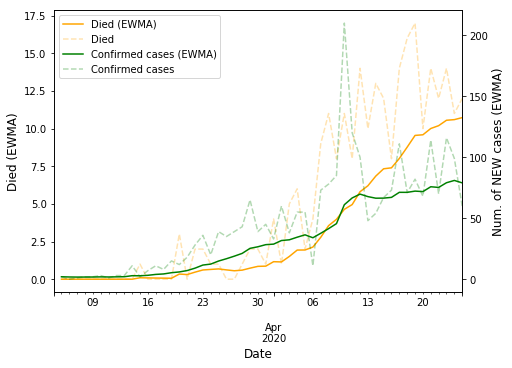

In [467]:
fig = plt.figure(figsize=(7, 5),constrained_layout=True)
gs = fig.add_gridspec(1, 1)
ax1= fig.add_subplot(gs[:1, :1])

df['Died'].diff().ewm(halflife=7,adjust=False).mean().plot(color='orange',label='Died (EWMA)')
df['Died'].diff().plot(style='--',color='orange',alpha=0.3,label='Died')

ax2 = ax1.twinx()
df['Total'].diff().ewm(halflife=7,adjust=False).mean().plot(color='green',label='Confirmed cases (EWMA)')
df['Total'].diff().plot(style='--',color='green',alpha=0.3,label='Confirmed cases')

ax1.set(ylabel='Died (EWMA)')
ax2.set(ylabel='Num. of NEW cases (EWMA)')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

lines = lines_1 + lines_2
labels = labels_1 + labels_2

ax1.legend(lines, labels, loc='upper left')